# 5. Neural Networks

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_mldata
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import accuracy_score
%matplotlib inline

import prml.neural_networks as pn

## 5.1 Feed-forward Network Functions

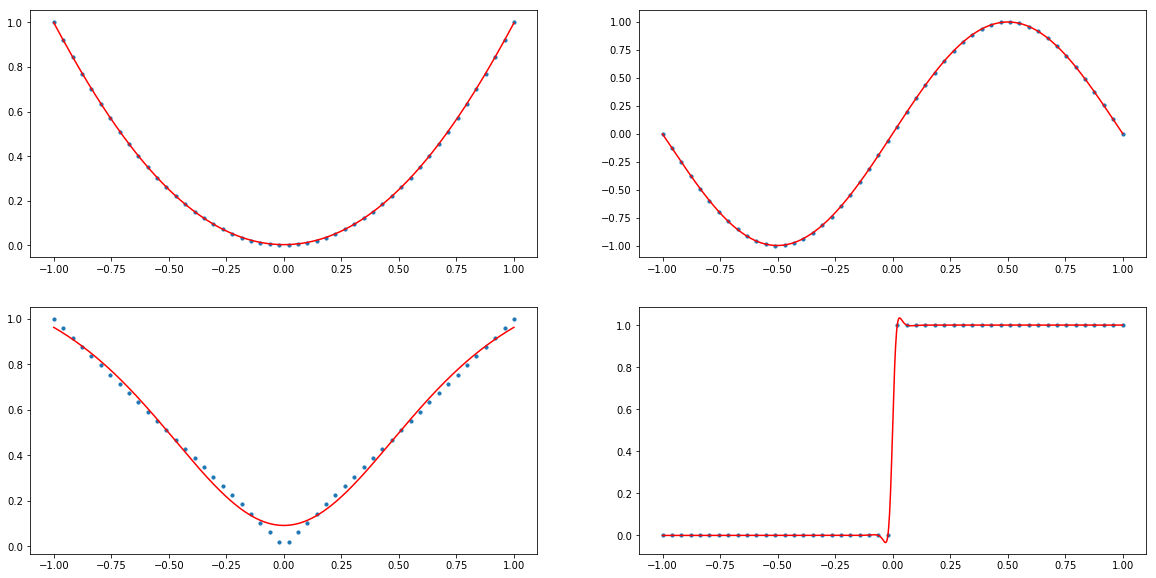

In [2]:
def create_toy_data(func, n=50):
    x = np.linspace(-1, 1, n)[:, None].astype(np.float32)
    return x, func(x)

def sinusoidal(x):
    return np.sin(np.pi * x)

def heaviside(x):
    return 0.5 * (np.sign(x) + 1)

func_list = [np.square, sinusoidal, np.abs, heaviside]
plt.figure(figsize=(20, 10))
x = np.float32(np.linspace(-1, 1, 1000)[:, None])
for i, func, n_iter, lr in zip(range(1, 5), func_list, [10000, 10000, 100000, 100000], [1e-2, 1e-2, 1e-4, 1e-3]):
    plt.subplot(2, 2, i)
    x_train, y_train = create_toy_data(func)
    model = pn.Network()
    model.add(pn.layers.MatMul(1, 3))
    model.add(pn.layers.BiasAdd(3))
    model.add(pn.layers.Tanh())
    model.add(pn.layers.MatMul(3, 1))
    model.add(pn.layers.BiasAdd(1))
    cost_func = pn.losses.SquaredError()
    optimizer = pn.optimizers.AdamOptimizer(model, lr)
    for _ in range(n_iter):
        y = model.forward(x_train, training=True)
        delta = cost_func.backward(y, y_train)
        model.backward(delta)
        optimizer.update()
    y = model.forward(x)
    plt.scatter(x_train, y_train, s=10)
    plt.plot(x, y, color="r")
plt.show()

## 5.3 Error Backpropagation

In [3]:
def create_toy_data():
    x = np.random.uniform(-1., 1., size=(100, 2)).astype(np.float32)
    labels = (np.prod(x, axis=1) > 0).astype(np.float32)
    return x, labels.reshape(-1, 1)

x_train, y_train = create_toy_data()

model = pn.Network()
model.add(pn.layers.MatMul(2, 4))
model.add(pn.layers.BiasAdd(4))
model.add(pn.layers.Tanh())
model.add(pn.layers.MatMul(4, 1))
model.add(pn.layers.BiasAdd(1))
cost_func = pn.losses.SigmoidCrossEntropy()
optimizer = pn.optimizers.GradientDescentOptimizer(model, 1e-3)

for i in range(100000):
    logit = model.forward(x_train, training=True)
    if i % 10000 == 0:
        cost = cost_func(logit, y_train)
        print("step %6d, cost %f" % (i, cost))
    delta = cost_func.backward(logit, y_train)
    model.backward(delta)
    optimizer.update()

step      0, cost 67.721550
step  10000, cost 6.534441
step  20000, cost 4.538944
step  30000, cost 3.536737
step  40000, cost 2.933440
step  50000, cost 2.525536
step  60000, cost 2.227563
step  70000, cost 1.998333
step  80000, cost 1.815429
step  90000, cost 1.665499


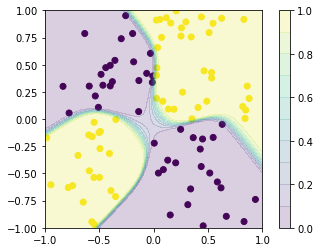

In [4]:
x0, x1 = np.meshgrid(np.linspace(-1, 1, 100), np.linspace(-1, 1, 100))
x = np.array([x0, x1]).reshape(2, -1).T.astype(np.float32)
logit = model.forward(x).reshape(100, 100)
y = cost_func.forward(logit)

levels = np.linspace(0, 1, 11)
plt.scatter(x_train[:, 0], x_train[:, 1], c=y_train)
plt.contourf(x0, x1, y, levels, alpha=0.2)
plt.colorbar()
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

## 5.5 Regularization in Neural Networks

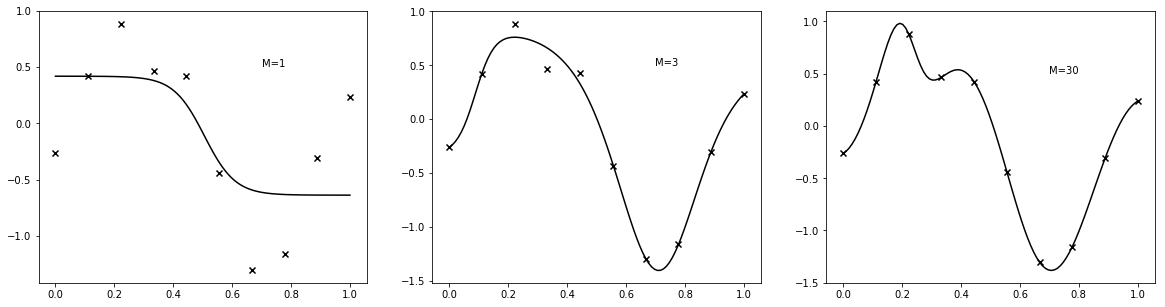

In [5]:
def create_toy_data(n=10):
    x = np.linspace(0, 1, n)[:, None].astype(np.float32)
    return x, np.sin(2 * np.pi * x) + np.random.normal(scale=0.25, size=(10, 1)).astype(np.float32)

x_train, y_train = create_toy_data()
x = np.linspace(0, 1, 100)[:, None].astype(np.float32)

plt.figure(figsize=(20, 5))
for i, m in enumerate([1, 3, 30]):
    plt.subplot(1, 3, i + 1)
    model = pn.Network()
    model.add(pn.layers.MatMul(1, m))
    model.add(pn.layers.BiasAdd(m))
    model.add(pn.layers.Tanh())
    model.add(pn.layers.MatMul(m, 1))
    model.add(pn.layers.BiasAdd(1))
    cost_func = pn.losses.SquaredError()
    optimizer = pn.optimizers.AdamOptimizer(model)
    for j in range(10000 * m):
        y = model.forward(x_train, training=True)
        delta = cost_func.backward(y, y_train)
        model.backward(delta)
        optimizer.update()
    y = model.forward(x)
    plt.scatter(x_train, y_train, marker="x", color="k")
    plt.plot(x, y, color="k")
    plt.annotate("M={}".format(m), (0.7, 0.5))
plt.show()

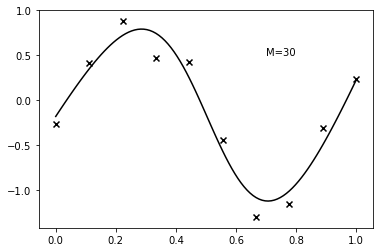

In [6]:
model = pn.Network()
model.add(pn.layers.MatMul(1, 30))
model.add(pn.layers.BiasAdd(30))
model.add(pn.layers.Tanh())
model.add(pn.layers.MatMul(30, 1))
model.add(pn.layers.BiasAdd(1))
cost_func = pn.losses.SquaredError()
penalty_func = pn.losses.WeightDecay(1e-2)
optimizer = pn.optimizers.AdamOptimizer(model)
for i in range(300000):
    y = model.forward(x_train, training=True)
    delta = cost_func.backward(y, y_train)
    model.backward(delta)
    penalty_func.backward(model)
    optimizer.update()
y = model.forward(x)
plt.scatter(x_train, y_train, marker="x", color="k")
plt.plot(x, y, color="k")
plt.annotate("M=30", (0.7, 0.5))
plt.show()

In [7]:
def create_toy_data():
    x = np.random.uniform(-1., 1., size=(100, 2)).astype(np.float32)
    labels = (np.prod(x, axis=1) > 0).astype(np.float32)
    return x, labels.reshape(-1, 1)

x_train, y_train = create_toy_data()

model_mle = pn.Network()
model_mle.add(pn.layers.MatMul(2, 4))
model_mle.add(pn.layers.BiasAdd(4))
model_mle.add(pn.layers.Tanh())
model_mle.add(pn.layers.MatMul(4, 1))
model_mle.add(pn.layers.BiasAdd(1))

model_map = pn.Network()
model_map.add(pn.layers.MatMul(2, 4))
model_map.add(pn.layers.BiasAdd(4))
model_map.add(pn.layers.Tanh())
model_map.add(pn.layers.MatMul(4, 1))
model_map.add(pn.layers.BiasAdd(1))

cost_func = pn.losses.SigmoidCrossEntropy()
penalty_func = pn.losses.WeightDecay(1.)
optimizer_mle = pn.optimizers.GradientDescentOptimizer(model_mle, 1e-3)
optimizer_map = pn.optimizers.GradientDescentOptimizer(model_map, 1e-3)

for i in range(100000):
    logit_mle = model_mle.forward(x_train, training=True)
    logit_map = model_map.forward(x_train, training=True)
    delta_mle = cost_func.backward(logit_mle, y_train)
    delta_map = cost_func.backward(logit_map, y_train)
    model_mle.backward(delta_mle)
    model_map.backward(delta_map)
    penalty_func.backward(model_map)
    optimizer_mle.update()
    optimizer_map.update()

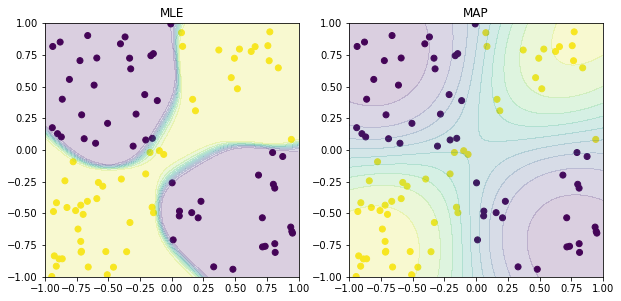

In [8]:
x0, x1 = np.meshgrid(np.linspace(-1, 1, 100), np.linspace(-1, 1, 100))
x = np.array([x0, x1]).reshape(2, -1).T.astype(np.float32)
y_mle = cost_func.forward(model_mle.forward(x)).reshape(100, 100)
y_map = cost_func.forward(model_map.forward(x)).reshape(100, 100)

levels = np.linspace(0, 1, 11)
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.scatter(x_train[:, 0], x_train[:, 1], c=y_train)
plt.contourf(x0, x1, y_mle, levels, alpha=0.2)
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.gca().set_aspect('equal', adjustable='box')
plt.title("MLE")
plt.subplot(1, 2, 2)
plt.scatter(x_train[:, 0], x_train[:, 1], c=y_train)
plt.contourf(x0, x1, y_map, levels, alpha=0.2)
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.gca().set_aspect('equal', adjustable='box')
plt.title("MAP")
plt.show()

### 5.5.6 Convolutional networks

In [9]:
def load_mnist():
    mnist = fetch_mldata("MNIST original")
    x = mnist.data.astype(np.float32)
    label = mnist.target

    x /= np.max(x, axis=1, keepdims=True)
    x = x.reshape(-1, 28, 28, 1)

    x_train, x_test, label_train, label_test = train_test_split(x, label, test_size=0.1)
    y_train = LabelBinarizer().fit_transform(label_train).astype(np.float32)
    return x_train, x_test, y_train, label_test
x_train, x_test, y_train, label_test = load_mnist()

In [10]:
model = pn.Network()
model.add(pn.layers.Convolution2d(1, 32, 5, pad=2, std=0.1))
model.add(pn.layers.BiasAdd(32, value=0.1))
model.add(pn.layers.ReLU())
model.add(pn.layers.MaxPooling2d(2, stride=2))

model.add(pn.layers.Convolution2d(32, 64, 5, pad=2, std=0.1))
model.add(pn.layers.BiasAdd(64, value=0.1))
model.add(pn.layers.ReLU())
model.add(pn.layers.MaxPooling2d(2, stride=2))

model.add(pn.layers.Reshape((-1, 7 * 7 * 64)))
model.add(pn.layers.MatMul(7 * 7 * 64, 1024, std=0.1))
model.add(pn.layers.BiasAdd(1024, value=0.1))
model.add(pn.layers.ReLU())
model.add(pn.layers.Dropout(prob=0.5))

model.add(pn.layers.MatMul(1024, 10, std=0.1))
model.add(pn.layers.BiasAdd(10, value=0.1))

cost_func = pn.losses.SoftmaxCrossEntropy()
optimizer = pn.optimizers.AdamOptimizer(model, 1e-4)

for epoch in range(1, 11):
    indices = np.random.permutation(len(x_train))
    for i, index in enumerate(range(0, len(x_train), 50)):
        x_batch = x_train[indices[index: index + 50]]
        y_batch = y_train[indices[index: index + 50]]
        if i % 100 == 0:
            logit = model.forward(x_batch)
            accuracy = accuracy_score(
                np.argmax(y_batch, axis=-1), np.argmax(logit, axis=-1))
            cost = cost_func(logit, y_batch)
            print("epoch {0:02d}".format(epoch), end=", ")
            print("step {0:04d}".format(i), end=", ")
            print("accuracy {0:.2f}".format(accuracy), end=", ")
            print("cost {0:g}".format(cost))
        logit = model.forward(x_batch, training=True)
        delta = cost_func.backward(logit, y_batch)
        model.backward(delta)
        optimizer.update()

epoch 01, step 0000, accuracy 0.10, cost 114.8
epoch 01, step 0100, accuracy 0.44, cost 102.968
epoch 01, step 0200, accuracy 0.88, cost 24.6988
epoch 01, step 0300, accuracy 0.88, cost 18.2517
epoch 01, step 0400, accuracy 0.94, cost 15.0277
epoch 01, step 0500, accuracy 0.92, cost 12.4529
epoch 01, step 0600, accuracy 0.92, cost 11.7074
epoch 01, step 0700, accuracy 0.94, cost 8.21985
epoch 01, step 0800, accuracy 0.96, cost 11.8143
epoch 01, step 0900, accuracy 0.88, cost 15.9827
epoch 01, step 1000, accuracy 0.92, cost 9.13297
epoch 01, step 1100, accuracy 0.96, cost 5.18841
epoch 01, step 1200, accuracy 0.96, cost 7.30461
epoch 02, step 0000, accuracy 0.88, cost 12.998
epoch 02, step 0100, accuracy 0.94, cost 6.83493
epoch 02, step 0200, accuracy 0.96, cost 6.71429
epoch 02, step 0300, accuracy 0.90, cost 17.0316
epoch 02, step 0400, accuracy 1.00, cost 3.1559
epoch 02, step 0500, accuracy 0.96, cost 5.17455
epoch 02, step 0600, accuracy 1.00, cost 3.50987
epoch 02, step 0700, acc

In [11]:
label_pred = []
for i in range(0, len(x_test), 50):
    label_pred.append(np.argmax(model.forward(x_test[i: i + 50]), axis=-1))
label_pred = np.asarray(label_pred).ravel()
print("accuracy (test)", accuracy_score(label_test, label_pred))

accuracy (test) 0.989142857143


## 5.6 Mixture Density Networks

In [12]:
def create_toy_data(func, n=300):
    t = np.random.uniform(size=(n, 1))
    x = func(t) + np.random.uniform(-0.05, 0.05, size=(n, 1))
    return x.astype(np.float32), t.astype(np.float32)

def func(x):
        return x + 0.3 * np.sin(2 * np.pi * x)
    
def sample(x, t, n=None):
    assert len(x) == len(t)
    N = len(x)
    if n is None:
        n = N
    indices = np.random.choice(N, n, replace=False)
    return x[indices], t[indices]

x_train, y_train = create_toy_data(func)

In [13]:
model = pn.Network()
model.add(pn.layers.MatMul(1, 5, std=0.1))
model.add(pn.layers.BiasAdd(5))
model.add(pn.layers.Tanh())
model.add(pn.layers.MatMul(5, 9, std=0.1))
model.add(pn.layers.BiasAdd(9))
cost_func = pn.losses.GaussianMixtureNLL(n_components=3)
optimizer = pn.optimizers.AdamOptimizer(model, 1e-4)

for i in range(100000):
    batch = sample(x_train, y_train, n=100)
    logit = model.forward(batch[0], training=True)
    delta = cost_func.backward(logit, batch[1])
    model.backward(delta)
    optimizer.update()

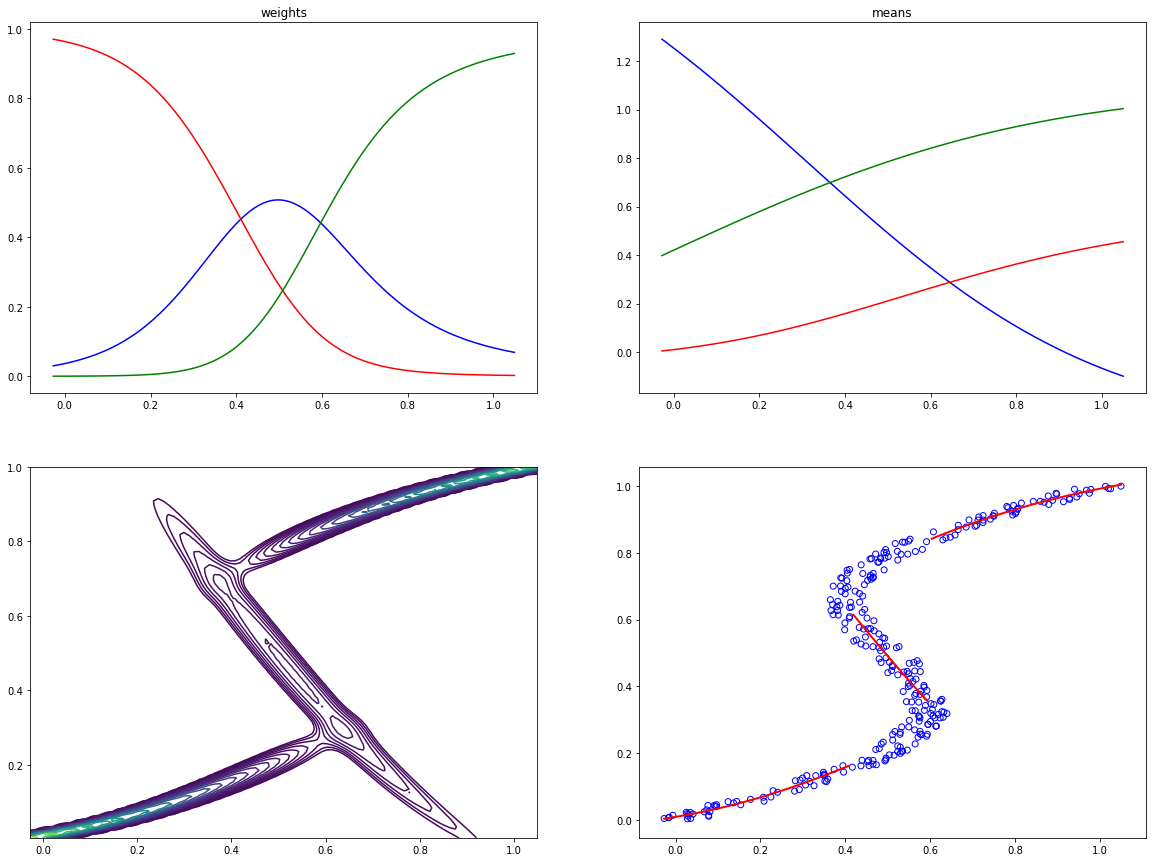

In [14]:
x, y = np.meshgrid(
    np.linspace(x_train.min(), x_train.max(), 100),
    np.linspace(y_train.min(), y_train.max(), 100))
xy = np.array([x, y]).reshape(2, -1).T.astype(np.float32)

logit = model.forward(xy[:, 0].reshape(-1, 1))
sigma, weight, mu = cost_func.forward(logit)
probs = cost_func.gauss(mu, sigma, xy[:, 1].reshape(-1, 1))
probs = np.sum(weight * probs, axis=1).reshape(100, 100)

plt.figure(figsize=(20, 15))
plt.subplot(2, 2, 1)
plt.plot(x[0], weight[:100, 0], color="blue")
plt.plot(x[0], weight[:100, 1], color="red")
plt.plot(x[0], weight[:100, 2], color="green")
plt.title("weights")

plt.subplot(2, 2, 2)
plt.plot(x[0], mu[:100, 0], color="blue")
plt.plot(x[0], mu[:100, 1], color="red")
plt.plot(x[0], mu[:100, 2], color="green")
plt.title("means")

plt.subplot(2, 2, 3)
levels_log = np.linspace(0, np.log(probs.max()), 21)
levels = np.exp(levels_log)
levels[0] = 0
plt.contour(x, y, probs, levels)
plt.xlim(x_train.min(), x_train.max())
plt.ylim(y_train.min(), y_train.max())

plt.subplot(2, 2, 4)
argmax = np.argmax(weight[:100], axis=1)
for i in range(3):
    indices = np.where(argmax == i)[0]
    plt.plot(x[0, indices], mu[(indices, np.zeros_like(indices) + i)], color="r", linewidth=2)
plt.scatter(x_train, y_train, facecolor="none", edgecolor="b")
plt.show()

## 5.7 Bayesian Neural Networks